# Assumption



The original orders have been deleted if there are return orders 

# Data Collection & Preparation

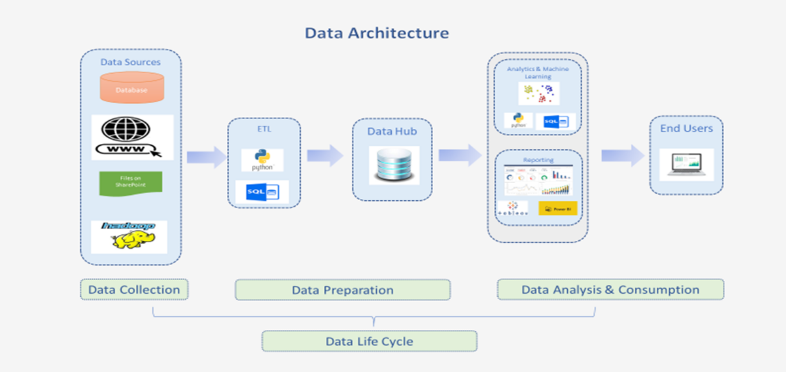

## 1.Import python packages

In [1]:
import pandas as pd
import numpy as np
import os
import re
import datetime
file_path='C:/Business_Data_Analysis/data/'
# file_path=os.environ['USERPROFILE']+'/Business_Data_Analysis/'

# %pip install nbconvert

## 2.Establish connection to database

In [2]:
import pyodbc
import urllib
import sqlalchemy

      
'''destination databases'''

params_datahub = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};"
                                 "SERVER=localhost\SQLEXPRESS;"
                                 "DATABASE=datahub;"
                                 "UID=sa;"
                                 "PWD=user1")

engine_datahub = sqlalchemy.create_engine("mssql+pyodbc:///?odbc_connect={}".format(params_datahub))

## 3.ETL data to datahub

In [3]:
import glob
from pathlib import Path
xls = pd.ExcelFile(file_path+'CRM.xlsx')
xls.sheet_names

['users', 'orders', 'stores']

In [4]:
df_users = pd.read_excel(file_path+'CRM.xlsx', sheet_name="users")
df_users.head()

,user_id,attribution,sign-up,date_first_order,date_last_order
0,002844eb-99c8-444e-a0b9-30dc301748cb,A,2018-01-13 19:14:41.197,2019-05-16 22:11:12.045,2020-03-03 22:43:26.696
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,A,2017-11-29 21:41:46.245,2018-05-27 12:52:10.999,2020-02-23 14:51:55.901
2,00ea65c2-ccd7-4075-a581-68e46681b87f,C,2018-04-26 01:14:02.471,2018-04-26 01:26:08.217,2020-03-07 20:01:40.163
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,B,2016-04-04 22:01:06.015,2017-06-05 03:01:20.753,2017-06-05 03:01:20.753
4,01427b21-4c6f-40f0-a893-3949ef2a326e,B,2019-02-25 19:09:29.147,2019-02-25 19:35:33.775,2019-03-25 22:08:47.500


In [5]:
df_orders = pd.read_excel(file_path+'CRM.xlsx', sheet_name="orders",parse_dates=['order_date'])
df_orders.dtypes

user_id                         object
order_id                         int64
order_date         datetime64[ns, UTC]
store_branch_id                  int64
dtype: object

In [6]:
df_stores = pd.read_excel(file_path+'CRM.xlsx', sheet_name="stores")
df_stores.dtypes

store_branch_id    int64
store_id           int64
dtype: object

In [7]:
df_users['sign-up']=pd.to_datetime(df_users['sign-up'],format('%Y-%m-%d'))
df_users['date_first_order']=pd.to_datetime(df_users['date_first_order'],format('%Y-%m-%d'))
df_users['date_last_order']=pd.to_datetime(df_users['date_last_order'],format('%Y-%m-%d'))

In [8]:
df_users['date_first_order']=df_users['date_first_order'].dt.date

In [9]:
df_users['sign-up']=df_users['sign-up'].dt.date

In [10]:
df_users['date_last_order']=df_users['date_last_order'].dt.date

In [11]:
df_users.dtypes

user_id             object
attribution         object
sign-up             object
date_first_order    object
date_last_order     object
dtype: object

In [12]:
df_orders['order_date']=pd.to_datetime(df_orders['order_date'],format('%Y-%m-%d'))

In [13]:
df_orders['order_date']=df_orders['order_date'].dt.date

In [14]:
#df_users['sign-up']=pd.to_datetime(df_users['sign-up'],format('%Y-%m-%d'))
#df_users['date_first_order']=pd.to_datetime(df_users['date_first_order'],format('%Y-%m-%d'))
#df_users['date_last_order']=pd.to_datetime(df_users['date_last_order'],format('%Y-%m-%d'))

In [15]:
df_users.dtypes

user_id             object
attribution         object
sign-up             object
date_first_order    object
date_last_order     object
dtype: object

In [16]:
df_orders.dtypes

user_id            object
order_id            int64
order_date         object
store_branch_id     int64
dtype: object

In [17]:
df_users.to_sql("df_users", engine_datahub, if_exists='replace',index=False)
df_orders.to_sql("df_orders", engine_datahub,if_exists='replace',index=False)
df_stores.to_sql("df_stores", engine_datahub,if_exists='replace',index=False)         

## 4.Get data from source database

In [18]:
df_users=pd.read_sql_table(r"df_users",engine_datahub)
df_orders=pd.read_sql_table(r"df_orders",engine_datahub)
df_stores=pd.read_sql_table(r"df_stores",engine_datahub)

In [19]:
# understand the data 
df_users.shape, df_orders.shape,df_stores.shape

((499, 5), (9682, 4), (557, 2))

In [20]:
# count the total number of missing values
pd.isnull(df_users).sum().sum(),
pd.isnull(df_orders).sum().sum(),
pd.isnull(df_stores).sum().sum(),

(0,)

In [21]:
# Drop Duplicate
df_users.drop_duplicates(keep='first', inplace=True)
df_orders.drop_duplicates(keep='first', inplace=True)
df_stores.drop_duplicates(keep='first', inplace=True)

In [22]:
df_users.shape, df_orders.shape,df_stores.shape

((499, 5), (9682, 4), (557, 2))

In [23]:
# Append all the orders into one table
df1=df_users[['user_id','date_first_order']]
df1 =df1.rename(columns = {'date_first_order':'order_date'})
df2=df_users[['user_id','date_last_order']]
df2 =df2.rename(columns = {'date_last_order':'order_date'})
df3=df_orders[['user_id','order_date']]
all_orders = df1.append(df2).append(df3)
all_orders.dtypes

user_id               object
order_date    datetime64[ns]
dtype: object

In [24]:
import datetime as dt
all_orders['order_date']=pd.to_datetime(all_orders['order_date'],format('%Y-%m-%d'))

In [25]:
df_users.to_sql("all_orders", engine_datahub, if_exists='replace',index=False)

In [26]:
all_orders.dtypes

user_id               object
order_date    datetime64[ns]
dtype: object

In [27]:
print(all_orders['order_date'].max())

2020-03-15 00:00:00


In [28]:
today_date = dt.datetime(2020,3,16)

In [29]:
df_users['signtoorder']=(df_users['date_first_order']-df_users['sign-up']).dt.days/30
df_users['lengthofclient']=(df_users['date_last_order']-df_users['date_first_order']).dt.days/30

In [30]:
df_users.dtypes

user_id                     object
attribution                 object
sign-up             datetime64[ns]
date_first_order    datetime64[ns]
date_last_order     datetime64[ns]
signtoorder                float64
lengthofclient             float64
dtype: object

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns


<AxesSubplot:xlabel='lengthofclient', ylabel='Count'>

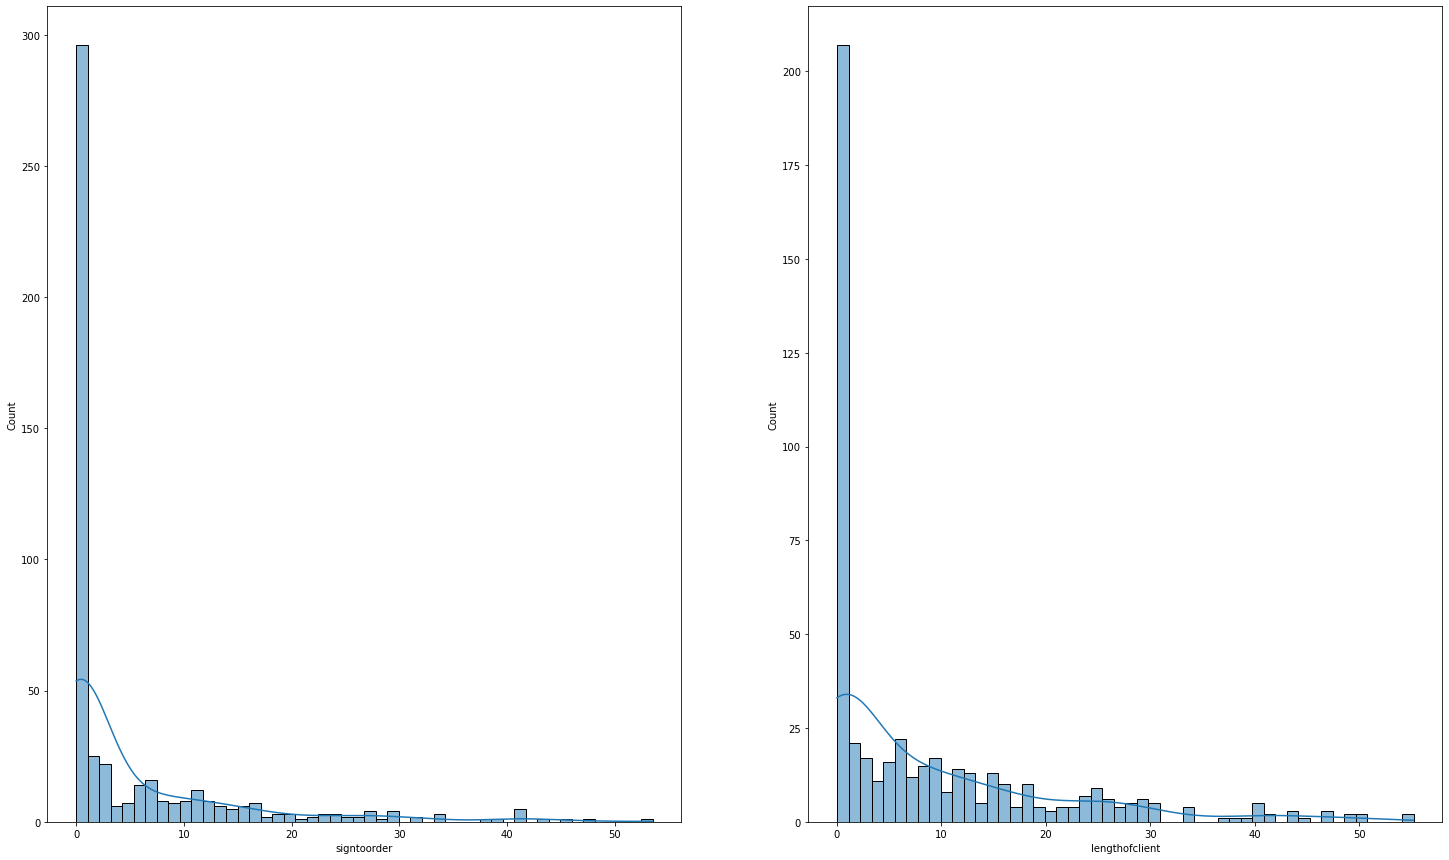

In [32]:
fig, ax = plt.subplots(1,2, figsize=(25,15))

sns.histplot(df_users['signtoorder'], ax=ax[0],bins=50,kde=True)
sns.histplot(df_users['lengthofclient'],ax=ax[1], bins=50,kde=True)

In [33]:
totalNoofcustomer =df_users['user_id'].nunique()
totalNoofcustomer

499

Insights

1, As we can see, it typically takes one month from sign-up to first purchase. After that, customers are likely to leave, making the first month crucial for retaining them.                     

2,Only 5% (25/499) of customers remained for a longer time with the business after their first purchase, and the first month following the initial purchase  is vital for customers to continue with the company.

In [34]:
all_orders.head()

,user_id,order_date
0,002844eb-99c8-444e-a0b9-30dc301748cb,2019-05-16
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,2018-05-27
2,00ea65c2-ccd7-4075-a581-68e46681b87f,2018-04-26
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,2017-06-05
4,01427b21-4c6f-40f0-a893-3949ef2a326e,2019-02-25


In [35]:
df_c_g=all_orders.groupby('user_id').agg({'order_date':['count','min','max']})
df_c_g.columns = ["_".join(col_name).rstrip('_') for col_name in df_c_g.columns.to_flat_index()]
df_c_g=df_c_g.reset_index()
df_c_g.head()

,user_id,order_date_count,order_date_min,order_date_max
0,002844eb-99c8-444e-a0b9-30dc301748cb,41,2019-05-16,2020-03-03
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,14,2018-05-25,2020-02-23
2,00ea65c2-ccd7-4075-a581-68e46681b87f,58,2018-04-11,2020-03-07
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,3,2017-06-02,2017-06-05
4,01427b21-4c6f-40f0-a893-3949ef2a326e,6,2019-02-21,2019-03-25


# segmentation

In [36]:
print(all_orders['order_date'].max())

2020-03-15 00:00:00


In [37]:
today_date = dt.datetime(2020,3,16)

In [38]:
df_c_g.head()

,user_id,order_date_count,order_date_min,order_date_max
0,002844eb-99c8-444e-a0b9-30dc301748cb,41,2019-05-16,2020-03-03
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,14,2018-05-25,2020-02-23
2,00ea65c2-ccd7-4075-a581-68e46681b87f,58,2018-04-11,2020-03-07
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,3,2017-06-02,2017-06-05
4,01427b21-4c6f-40f0-a893-3949ef2a326e,6,2019-02-21,2019-03-25


In [39]:
df_c_g['recency_score'] = pd.qcut(df_c_g['order_date_max'],5,labels=[1, 2, 3, 4, 5],duplicates='drop')
df_c_g['frequency_score'] = pd.qcut(df_c_g['order_date_count'].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5],duplicates='drop')
df_c_g['RF_SCORE'] = (df_c_g['recency_score'].astype(str) + df_c_g['frequency_score'].astype(str))


In [40]:
df_c_g.head()

,user_id,order_date_count,order_date_min,order_date_max,recency_score,frequency_score,RF_SCORE
0,002844eb-99c8-444e-a0b9-30dc301748cb,41,2019-05-16,2020-03-03,5,5,55
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,14,2018-05-25,2020-02-23,5,4,54
2,00ea65c2-ccd7-4075-a581-68e46681b87f,58,2018-04-11,2020-03-07,5,5,55
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,3,2017-06-02,2017-06-05,1,1,11
4,01427b21-4c6f-40f0-a893-3949ef2a326e,6,2019-02-21,2019-03-25,2,3,23


In [41]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

df_c_g['segment'] = df_c_g['RF_SCORE'].replace(seg_map, regex = True)

df_c_g.head()

,user_id,order_date_count,order_date_min,order_date_max,recency_score,frequency_score,RF_SCORE,segment
0,002844eb-99c8-444e-a0b9-30dc301748cb,41,2019-05-16,2020-03-03,5,5,55,champions
1,00e9077c-9778-4a93-ae7b-f0580d7c90bc,14,2018-05-25,2020-02-23,5,4,54,champions
2,00ea65c2-ccd7-4075-a581-68e46681b87f,58,2018-04-11,2020-03-07,5,5,55,champions
3,010327ad-474c-4b0d-8503-fb0c7e16dc3d,3,2017-06-02,2017-06-05,1,1,11,hibernating
4,01427b21-4c6f-40f0-a893-3949ef2a326e,6,2019-02-21,2019-03-25,2,3,23,at_Risk


# Segmentation Map

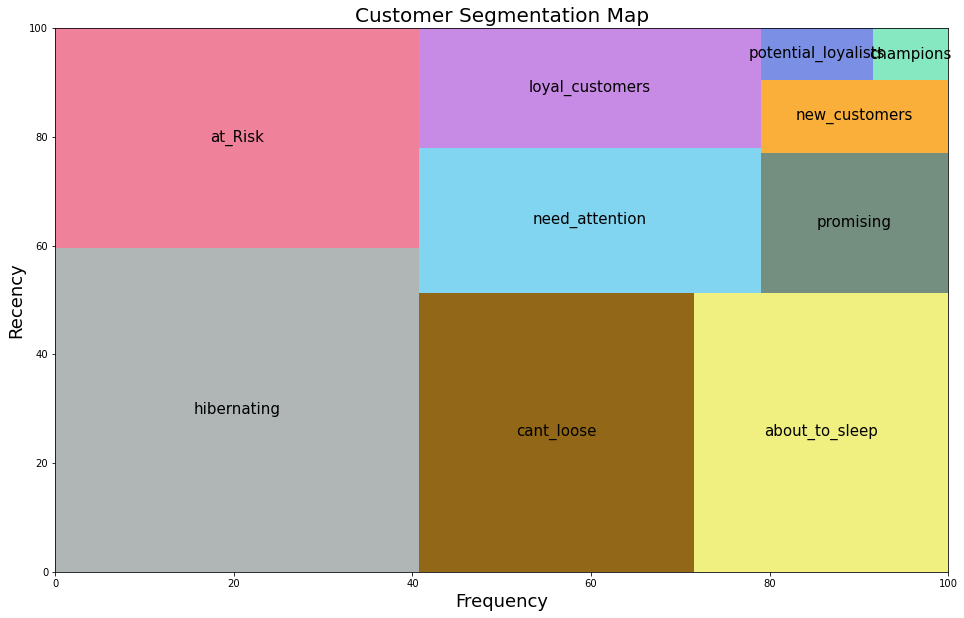

In [42]:
!pip install squarify
import squarify
segments = df_c_g['segment'].value_counts().sort_values(ascending = False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=segments,
              label=[label for label in seg_map.values()],
              color=['#AFB6B5', '#F0819A', '#926717', '#F0F081', '#81D5F0',
                     '#C78BE5', '#748E80', '#FAAF3A', '#7B8FE4', '#86E8C0'],
              pad = False,
              bar_kwargs = {'alpha': 1},
              text_kwargs = {'fontsize':15})
plt.title("Customer Segmentation Map", fontsize = 20)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Recency', fontsize = 18)
plt.show()

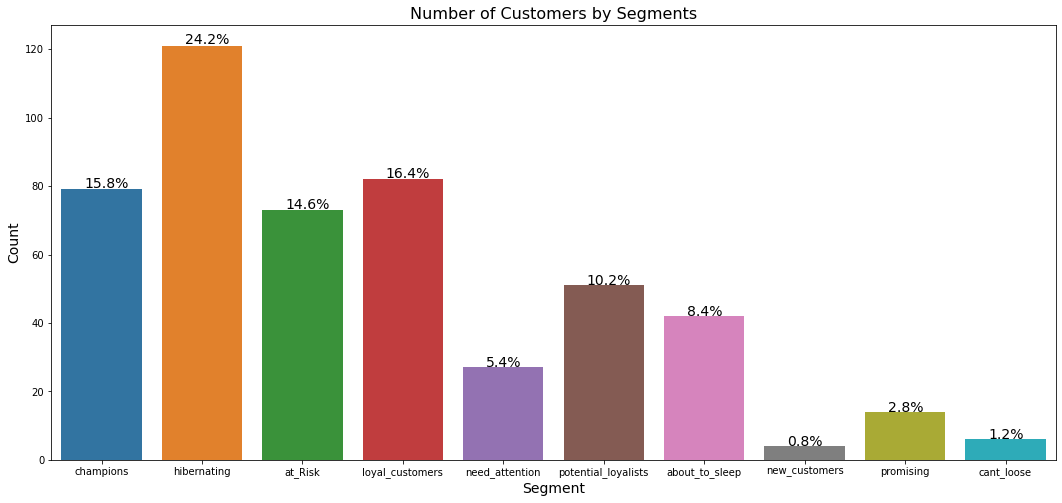

In [43]:
plt.figure(figsize = (18, 8))
ax = sns.countplot(data = df_c_g,
                   x = 'segment')
total = len(df_c_g.segment)
for patch in ax.patches:
    percentage = '{:.1f}%'.format(100 * patch.get_height()/total)
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(percentage, (x, y), size = 14)
plt.title('Number of Customers by Segments', size = 16)
plt.xlabel('Segment', size = 14)
plt.ylabel('Count', size = 14)
plt.xticks(size = 10)
plt.yticks(size = 10)
plt.show()

In [45]:
df_c_g.to_sql("customersegmetation", engine_datahub, if_exists='replace',index=False)